In [33]:
import os
import sys
import time
import yaml
import pandas as pd
import numpy as np
import re

with open('../../config.local.yaml', 'r') as f:
    local_config = yaml.safe_load(f)

LOCAL_PATH = local_config['LOCAL_PATH']

sys.path.append(os.path.join(LOCAL_PATH, "src/python"))

import data_tools as dt

from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from IPython.core.display import HTML
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from stargazer.stargazer import Stargazer

rng = np.random.default_rng(12898)

SUPPORT_TAGS = ['DEFINITELY SUPPORT', 'SOMEWHAT SUPPORT']
OPPOSE_TAGS = ['DEFINITELY OPPOSE', 'SOMEWHAT OPPOSE']
ORDERED_TAGS = ['DEFINITELY SUPPORT', 'SOMEWHAT SUPPORT', 'SOMEWHAT OPPOSE', 'DEFINITELY OPPOSE']

APPROVE_TAGS = ['APPROVED', 'APPROVED IN PART OR WITH MODIFICATIONS']



In [34]:
dfa = dt.get_agenda_items(verbose=False)
dfm = dt.get_minutes(verbose=False)
dfl = dt.get_supplemental_docs(verbose=False)
dfc = dt.get_cases(verbose=False)

In [35]:
# Distribution of commission members and council districts

mydf = dfm.merge(dfa[['date','item_no','council_district']], on=['date','item_no'], how='left')
assert mydf['council_district'].isna().sum() == 0

from data_tools import MEMBERS
CDS = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','CITYWIDE']
table = {}
for member in MEMBERS:
    table[member] = {}
    for cd in CDS:
        table[member][cd] = 0

for idx, row in mydf.iterrows():
    cds = row['council_district'].split(',')
    moved = row['moved']
    for cd in cds:
        table[moved][cd.strip()] += 1

table = pd.DataFrame(table).T
table

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,CITYWIDE
AMBROZ,10,8,4,4,4,2,1,1,2,2,7,1,12,14,3,8
CABILDO,1,0,3,0,3,0,0,0,0,0,3,1,2,1,1,3
CAMPBELL,2,0,0,1,1,1,1,1,0,0,3,0,1,1,0,0
CHOE,1,3,3,5,2,3,4,4,2,4,5,3,7,4,0,3
DAKE WILSON,5,4,1,9,9,1,0,0,0,5,4,2,13,14,1,3
DIAZ,0,0,0,1,0,0,0,0,0,1,1,0,1,2,0,2
GOLD,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0
HORNSTOCK,0,1,0,4,4,0,1,1,1,1,3,0,3,3,0,1
KHORSAND,2,3,3,7,5,2,2,2,0,3,3,2,6,3,2,1
KLEIN,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0


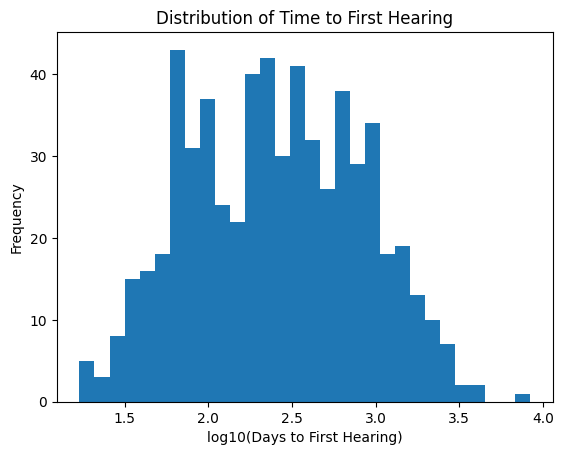

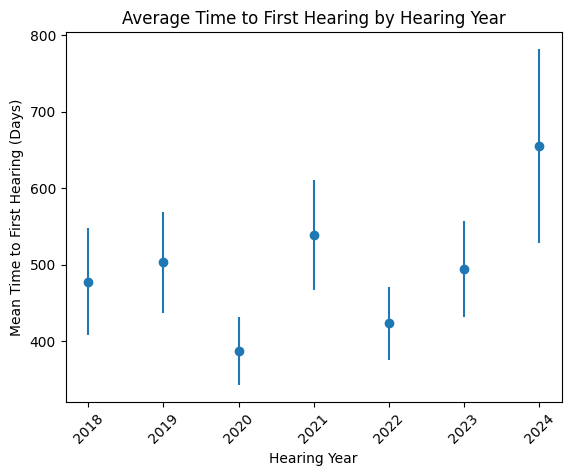

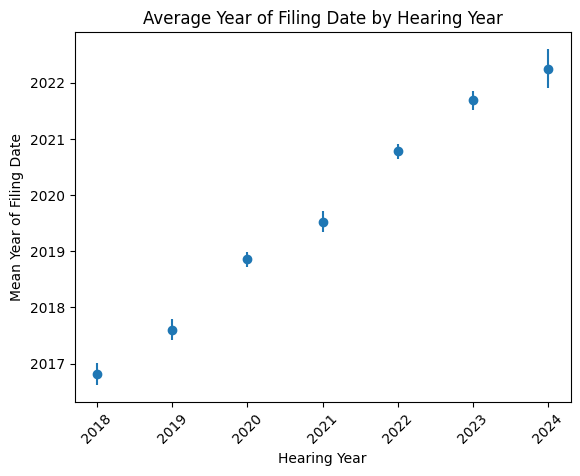

In [ ]:
# Distribution of time to hearing

mydf = dfm.merge(
    dfc[['casenum', 'filing_date']],
    left_on='title',
    right_on='casenum',
    how='left'
)

mydf = mydf.loc[mydf['filing_date'].notna()].reset_index(drop=True)
mydf['hearing_date'] = pd.to_datetime(mydf['date'], errors='coerce')
mydf['hearing_year'] = mydf['hearing_date'].dt.year
mydf['first_hearing_date'] = mydf.groupby(['title', 'filing_date'])['hearing_date'].transform('min')
mydf['n_hearings'] = mydf.groupby(['title', 'filing_date'])['hearing_date'].transform('count')
mydf = mydf.sort_values(by=['filing_date', 'hearing_date'], ascending=True).reset_index(drop=True)
mydf['time_to_first_hearing'] = (mydf['first_hearing_date'] - pd.to_datetime(mydf['filing_date'])).dt.days

# histogram of time to first hearing using matplotlib
plotdf = mydf[['title', 'filing_date', 'first_hearing_date', 'time_to_first_hearing']].drop_duplicates()
plt.hist(np.log10(plotdf['time_to_first_hearing']), bins=30)
plt.xlabel('log10(Days to First Hearing)')
plt.ylabel('Frequency')
plt.title('Distribution of Time to First Hearing')
plt.show()

# dot plot of average time to first hearing by hearing year, with error bars
plotdf['hearing_year'] = plotdf['first_hearing_date'].dt.year
plotdf2 = plotdf.groupby(['hearing_year']).agg(
    mean_time=('time_to_first_hearing', 'mean'),
    std_time=('time_to_first_hearing', 'std'),
    count=('time_to_first_hearing', 'count')
).reset_index()
plotdf2['stderr_time'] = plotdf2['std_time'] / np.sqrt(plotdf2['count'])
plt.errorbar(plotdf2['hearing_year'], plotdf2['mean_time'], yerr=plotdf2['stderr_time'], fmt='o')
plt.xlabel('Hearing Year')
plt.ylabel('Mean Time to First Hearing (Days)')
plt.title('Average Time to First Hearing by Hearing Year')
plt.xticks(rotation=45)
plt.show()

# dot plot of average year of filing date by hearing year, with error bars
plotdf3 = plotdf.groupby(['hearing_year']).agg(
    mean_year=('filing_date', lambda x: x.dt.year.mean()),
    std_year=('filing_date', lambda x: x.dt.year.std()),
    count=('filing_date', 'count')
).reset_index()
plotdf3['stderr_year'] = plotdf3['std_year'] / np.sqrt(plotdf3['count'])
plt.errorbar(plotdf3['hearing_year'], plotdf3['mean_year'], yerr=plotdf3['stderr_year'], fmt='o')
plt.xlabel('Hearing Year')
plt.ylabel('Mean Year of Filing Date')
plt.title('Average Year of Filing Date by Hearing Year')
plt.xticks(rotation=45)
plt.show()


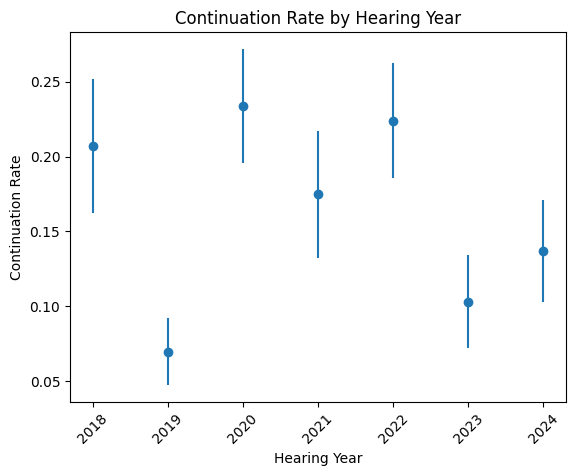

In [46]:
# dot plot of continuation rate by hearing year, with error bars

mydf = dfm.loc[dfm['project_result']!='WITHDRAWN'].copy()
mydf['denial_or_continuation'] = mydf['project_result'].isin([
    'DENIED', 'DELIBERATIONS CONTINUED TO FUTURE DATE'
])
mydf['hearing_year'] = pd.to_datetime(mydf['date']).dt.year
plotdf = mydf.groupby(['hearing_year']).agg(
    continuation_rate=('denial_or_continuation', 'mean'),
    count=('denial_or_continuation', 'count')
).reset_index()
plotdf['stderr'] = np.sqrt(plotdf['continuation_rate'] * (1 - plotdf['continuation_rate']) / plotdf['count'])
plt.errorbar(plotdf['hearing_year'], plotdf['continuation_rate'], yerr=plotdf['stderr'], fmt='o')
plt.xlabel('Hearing Year')
plt.ylabel('Continuation Rate')
plt.title('Continuation Rate by Hearing Year')
plt.xticks(rotation=45)
plt.show()